In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTENC
from scipy import sparse

In [4]:
#Step 1: data preparation
#drop irrevalant cols
df = pd.read_csv(r"/Users/zhangnan/Documents/2025ba/foundation of ba/group/bank+marketing/bank/bank-full.csv", sep=';')
keep_cols = ["age", "job", "marital", "education", "y"]
df = df[keep_cols].copy()

#dependent variable:Target to 0/1
y = df['y'].map({'no': 0, 'yes': 1})

#independent variable: Separate features
X = df.drop(columns=['y'])
cat_cols = ["job", "marital", "education"]
num_cols = ["age"]

In [5]:
#Step 2: Train–Test Split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [6]:
#Step 3: OrdinalEncode for SMOTENC (only fit on trainning data）

#1)SMOTENC requires “categorical features to be integer encoded” and needs the indices of categorical_features
ord_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1  
)
#2)only fit on train set
X_train_cat_int = ord_enc.fit_transform(X_train[cat_cols])
X_test_cat_int  = ord_enc.transform(X_test[cat_cols])

#3)Compose the matrix for SMOTENC
X_train_proc = np.column_stack([X_train_cat_int, X_train[num_cols].to_numpy()])
X_test_proc  = np.column_stack([X_test_cat_int,  X_test[num_cols].to_numpy()])

#4)The indices of the categorical columns in the matrix
cat_idx = list(range(len(cat_cols)))

print("Shapes | X_train_proc:", X_train_proc.shape, "| X_test_proc:", X_test_proc.shape)
print("cat_idx (for SMOTENC):", cat_idx)


Shapes | X_train_proc: (36168, 4) | X_test_proc: (9043, 4)
cat_idx (for SMOTENC): [0, 1, 2]


In [7]:
#Step 4: Apply SMOTENC on train set
smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train_proc, y_train)

print("Class balance (train) AFTER SMOTENC:",
      y_train_res.value_counts(normalize=True).round(3).to_dict())
print(f"Shapes | X_train: {X_train_proc.shape} -> {X_train_res.shape} | X_test: {X_test_proc.shape}")


Class balance (train) AFTER SMOTENC: {0: 0.5, 1: 0.5}
Shapes | X_train: (36168, 4) -> (63874, 4) | X_test: (9043, 4)


In [8]:
#Step 5: prepare for one-hot :resore the resampling train set to original

#1) divide X_train_res into "integer category part" and the "continuous numerical part."
n_cat = len(cat_cols)
X_train_res_cat_int = X_train_res[:, :n_cat]
X_train_res_num     = X_train_res[:, n_cat:]

#2) apply OrdinalEncoder.inverse_transform to gain original category data
X_train_res_cat_str = ord_enc.inverse_transform(X_train_res_cat_int)

#3) Assemble into a DataFrame 
X_train_res_df = pd.DataFrame(X_train_res_cat_str, columns=cat_cols)
X_train_res_df[num_cols[0]] = X_train_res_num[:, 0]  # age
 
X_test_df = X_test.copy()

#4) One-Hot：only fit on resampling trainning set, test set will be transformed by same encoder
oh_enc = OneHotEncoder(handle_unknown="ignore", sparse=True)
oh_enc.fit(X_train_res_df[cat_cols])

X_train_oh_cat = oh_enc.transform(X_train_res_df[cat_cols])  # sparse matrix
X_test_oh_cat  = oh_enc.transform(X_test_df[cat_cols])

#5)combine numberic cols(age)
X_train_age = sparse.csr_matrix(X_train_res_df[num_cols].to_numpy())
X_test_age  = sparse.csr_matrix(X_test_df[num_cols].to_numpy())

X_train_final = sparse.hstack([X_train_oh_cat, X_train_age], format="csr")
X_test_final  = sparse.hstack([X_test_oh_cat,  X_test_age],  format="csr")

#6) aquire feature name after onehot（optinal only necessary for importance report）
oh_feature_names = oh_enc.get_feature_names_out(cat_cols)## like['job_student', 'maritial_divorcesd']
final_feature_names = list(oh_feature_names) + num_cols
print("Final shapes | X_train_final:", X_train_final.shape, "| X_test_final:", X_test_final.shape)

Final shapes | X_train_final: (63874, 20) | X_test_final: (9043, 20)


In [9]:
#Step 6 data recheck
#1) y Match the number of x in rows
ok_rows = (X_train_final.shape[0] == y_train_res.shape[0]) and \
          (X_test_final.shape[0] == y_test.shape[0])
print("Row counts match (train/test):", ok_rows)


Row counts match (train/test): True


In [10]:
#2) same encoder for tranning and test
ok_cols = (X_train_final.shape[1] == X_test_final.shape[1])
print("Feature dims match (train vs test):", ok_cols)



Feature dims match (train vs test): True


In [11]:
# 3) ensure data is balanced after SMOTENC
try:
    train_balance = y_train_res.value_counts(normalize=True).round(3).to_dict()
except AttributeError:
    if 'np' in globals():  
        vals, cnts = np.unique(y_train_res, return_counts=True)
        total = cnts.sum()
        train_balance = {int(v): round(c/total, 3) for v, c in zip(vals, cnts)}
    else:
        total = len(y_train_res)
        ones = sum(int(v) == 1 for v in y_train_res)
        zeros = total - ones
        train_balance = {0: round(zeros/total, 3), 1: round(ones/total, 3)}

print("Train class balance (after SMOTENC):", train_balance)



Train class balance (after SMOTENC): {0: 0.5, 1: 0.5}


In [12]:
#Step 7: Train a baseline tree  then minimum evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score


In [13]:
#baseline model
clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=8,           
    min_samples_leaf=500,  # ratio of min_samples_leaf and sample ranges from 0.5% to 2% 
    min_samples_split=1000, #  2*min_samples_leaf
    random_state=42
)
clf.fit(X_train_final, y_train_res)

y_score_test  = clf.predict_proba(X_test_final)[:, 1]
y_score_train = clf.predict_proba(X_train_final)[:, 1]

print(f"Test  ROC-AUC: {roc_auc_score(y_test, y_score_test):.3f} | "
      f"PR-AUC: {average_precision_score(y_test, y_score_test):.3f}")
print(f"Train ROC-AUC: {roc_auc_score(y_train_res, y_score_train):.3f}")


Test  ROC-AUC: 0.635 | PR-AUC: 0.210
Train ROC-AUC: 0.657


In [14]:
#Step 8: modify tree by adjusting parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

#1) Construct a parameter grid
leaf_candidates = [400, 600, 800]
depth_candidates = [6, 8, 10]
param_grid = []
for leaf in leaf_candidates:
    param_grid.append({
        "max_depth": depth_candidates,
        "min_samples_leaf": [leaf],
        "min_samples_split": [2*leaf],
        "criterion": ["gini"]
    })

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_clf = DecisionTreeClassifier(random_state=42)

gcv = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring="roc_auc",      
    cv= cv,
    n_jobs=-1,
    verbose=0,
    refit=True              # use the best parameters to retrain tree  
)

gcv.fit(X_train_final, y_train_res)

print("Best params (CV):", gcv.best_params_)
print("Best CV ROC-AUC :", round(gcv.best_score_, 3))

#2) evaluate the best model 
best_clf = gcv.best_estimator_
y_score_test = best_clf.predict_proba(X_test_final)[:, 1]
y_score_train = best_clf.predict_proba(X_train_final)[:, 1]

test_roc = roc_auc_score(y_test, y_score_test)
test_pr  = average_precision_score(y_test, y_score_test)
train_roc = roc_auc_score(y_train_res, y_score_train)

print(f"[Best Tree] Test ROC-AUC: {test_roc:.3f} | PR-AUC: {test_pr:.3f}")
print(f"[Best Tree] Train ROC-AUC: {train_roc:.3f}")




Best params (CV): {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 400, 'min_samples_split': 800}
Best CV ROC-AUC : 0.659
[Best Tree] Test ROC-AUC: 0.638 | PR-AUC: 0.212
[Best Tree] Train ROC-AUC: 0.666


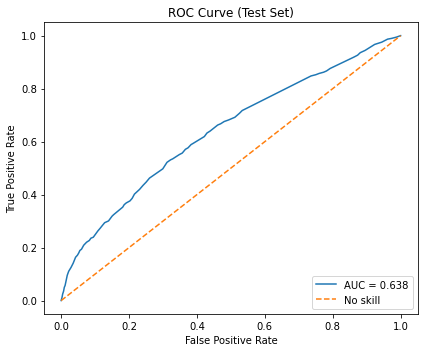

Test ROC-AUC: 0.638


In [15]:
#step 9: draw ROC curve（use the best_clf


# choose best tree
model = best_clf if 'best_clf' in globals() else clf

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# probality
y_score_test = model.predict_proba(X_test_final)[:, 1]
auc = roc_auc_score(y_test, y_score_test)

# ROC 
fpr, tpr, _ = roc_curve(y_test, y_score_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Test ROC-AUC: {auc:.3f}")


In [16]:
#Step 10: produce confusion matrix
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score
import numpy as np

#choose the best clf
model = best_clf if 'best_clf' in globals() else clf
y_prob = model.predict_proba(X_test_final)[:, 1]

#1) PR curve
prec, rec, thr = precision_recall_curve(y_test, y_prob)  # thr 对齐的是 prec[:-1]/rec[:-1]

target_recall = 0.80

#2) select the threshold with the highest precision among  "recall ≥ target"
idx = np.where(rec[:-1] >= target_recall)[0]
if len(idx) > 0:
    best = idx[np.argmax(prec[idx])]
    threshold = thr[best]
    reason = f"among points with recall≥{target_recall:.0%}, picked the one with max precision"
else:
    best = int(np.argmax(rec[:-1]))
    threshold = thr[best]
    reason = (f"target recall {target_recall:.0%} not reachable; "
              f"picked the max-recall point (recall≈{rec[:-1].max():.3f})")

#3) procude confusion matrix
y_pred = (y_prob >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(f"Threshold = {threshold:.4f}  ({reason})")
print(f"Precision = {precision_score(y_test, y_pred):.3f} | Recall = {recall_score(y_test, y_pred):.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):")
print(cm)


Threshold = 0.4007  (among points with recall≥80%, picked the one with max precision)
Precision = 0.132 | Recall = 0.848
Confusion matrix (rows=true 0/1, cols=pred 0/1):
[[2108 5877]
 [ 161  897]]


In [17]:
#step11: Grouped Permutation Importance (ROC-AUC on test)
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy import sparse

#1)grab model + test data
model = best_clf if 'best_clf' in globals() else clf
X = X_test_final
y = y_test

#2) get feature names
if 'final_feature_names' in globals():
    feature_names = np.array(final_feature_names)
else:
    try:
        feature_names = oh_enc.get_feature_names_out(cat_cols).tolist() + num_cols
        feature_names = np.array(feature_names)
    except Exception:
        # fallback: anonymous names
        feature_names = np.array([f"f{i}" for i in range(X.shape[1])])

#3) define groups
def idx_startswith(names, prefix):
    return np.where(np.char.startswith(names, prefix + "_"))[0]

grp = {}
grp['age']        = np.where(feature_names == 'age')[0]
grp['job']        = idx_startswith(feature_names, 'job')
grp['marital']    = idx_startswith(feature_names, 'marital')
grp['education']  = idx_startswith(feature_names, 'education')


if grp['age'].size == 0 and 'age' in feature_names.tolist():
    grp['age'] = np.array([np.where(feature_names == 'age')[0][0]])

#4) baseline AUC
y_prob_base = model.predict_proba(X)[:, 1]
auc_base = roc_auc_score(y, y_prob_base)

#5)grouped permutation (apply the SAME row permutation to all columns in the group)
def grouped_perm_drop(estimator, Xtest, ytest, col_idx, n_repeats=20, random_state=42):
    rng = np.random.RandomState(random_state)
    # work on a dense copy for simplicity & speed (test set is modest)
    if sparse.issparse(Xtest):
        Xd = Xtest.toarray()
    else:
        Xd = Xtest.copy()
    n = Xd.shape[0]
    drops = []
    for r in range(n_repeats):
        perm = rng.permutation(n)
        Xp = Xd.copy()
        Xp[:, col_idx] = Xd[perm][:, col_idx]  # keep intra-group structure, break relation with y
        y_prob = estimator.predict_proba(Xp)[:, 1]
        auc = roc_auc_score(ytest, y_prob)
        drops.append(auc_base - auc)  # positive means performance decreased -> feature matters
    return np.mean(drops), np.std(drops)

#6) run for each group
results = []
for g, idx in grp.items():
    if idx.size == 0:
        results.append((g, 0.0, 0.0, 0))  # group not present
        continue
    m, s = grouped_perm_drop(model, X, y, idx, n_repeats=20, random_state=42)
    results.append((g, m, s, idx.size))

#7) print sorted summary
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
print(f"Baseline Test ROC-AUC = {auc_base:.3f}")
print("Grouped permutation importance (drop in ROC-AUC; higher = more important):")
for g, mean_drop, std_drop, k in results_sorted:
    print(f"- {g:10s} | ΔAUC={mean_drop:.004f} ± {std_drop:.004f}  (cols={k})")


Baseline Test ROC-AUC = 0.638
Grouped permutation importance (drop in ROC-AUC; higher = more important):
- age        | ΔAUC=0.0784 ± 0.0061  (cols=1)
- education  | ΔAUC=0.0424 ± 0.0059  (cols=4)
- marital    | ΔAUC=0.0268 ± 0.0046  (cols=3)
- job        | ΔAUC=0.0191 ± 0.0042  (cols=12)


     |████████████████████████████████| 450 kB 722 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


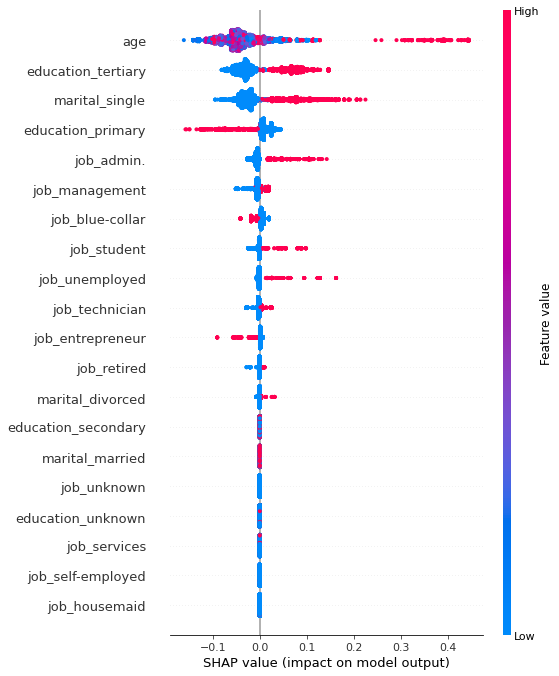

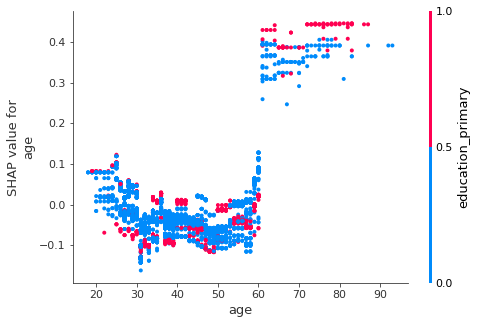

In [27]:
#step12:SHAP: global summary + age dependence
%pip install shap==0.43.0
import shap
import numpy as np


# pick model
model = best_clf if 'best_clf' in globals() else clf

# sample a manageable slice if test is large (optional)
X_shap = X_test_final
if X_shap.shape[0] > 10000:
    rng = np.random.RandomState(42)
    idx = rng.choice(X_shap.shape[0], size=8000, replace=False)
    if hasattr(X_shap, "toarray"):
        X_shap = X_shap[idx].toarray()
    else:
        X_shap = X_shap[idx]
    y_shap = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]
else:
    if hasattr(X_shap, "toarray"):
        X_shap = X_shap.toarray()
    y_shap = y_test

# feature names
if 'final_feature_names' in globals():
    feat_names = final_feature_names
else:
    # fallback generic names
    feat_names = [f"f{i}" for i in range(X_shap.shape[1])]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)   # for sklearn trees: returns list [class0, class1]
sv1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Global view
shap.summary_plot(sv1, X_shap, feature_names=feat_names, show=True)

# Single-feature dependence: age
if "age" in feat_names:
    shap.dependence_plot("age", sv1, X_shap, feature_names=feat_names, show=True)
else:
    print("Note: 'age' not found in feature names; skip dependence_plot.")


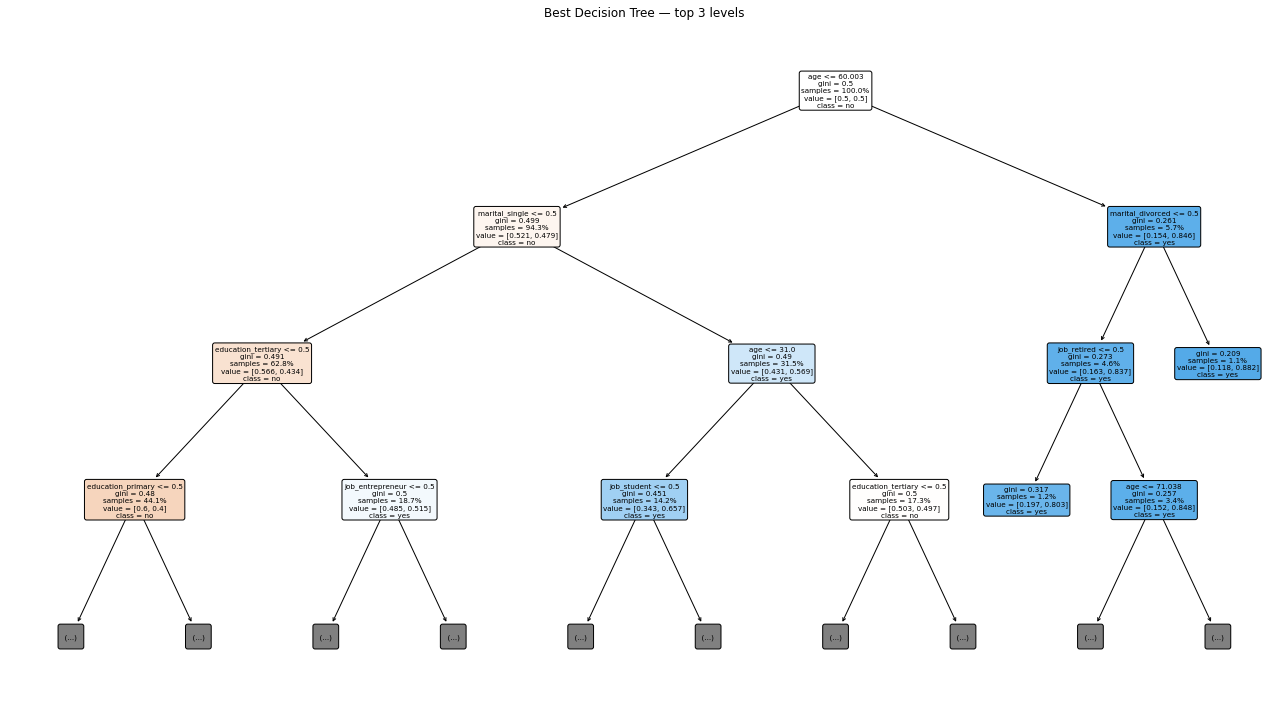

[Top 3 levels] test samples = 9043


,samples,proportion,pos_rate,rule
0,30,0.003,0.467,age > 60.00 AND marital_divorced=1
1,47,0.005,0.447,age > 60.00 AND marital_divorced=0 AND job_ret...
2,142,0.016,0.415,age > 60.00 AND marital_divorced=0 AND job_ret...
3,918,0.102,0.184,age ≤ 60.00 AND marital_single=1 AND age ≤ 31.00
4,1637,0.181,0.126,age ≤ 60.00 AND marital_single=1 AND age > 31.00
5,1677,0.185,0.120,age ≤ 60.00 AND marital_single=0 AND education...
6,4592,0.508,0.084,age ≤ 60.00 AND marital_single=0 AND education...


In [18]:
#Step 13: Best tree top-level plot + segment table =====
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set depth for display(too big to show all)
MAX_DEPTH_SHOW = 3

# using the best_clf and features 
model = best_clf if 'best_clf' in globals() else clf
feat_names = list(final_feature_names) if 'final_feature_names' in globals() else [f"f{i}" for i in range(X_train_final.shape[1])]

# 1) Draw only the first few layers to obtain the key splitting features
plt.figure(figsize=(18, 10))
plot_tree(model, feature_names=feat_names, class_names=["no","yes"],
          filled=True, rounded=True, max_depth=MAX_DEPTH_SHOW, proportion=True)
plt.title(f"Best Decision Tree — top {MAX_DEPTH_SHOW} levels")
plt.tight_layout(); plt.show()

# 2) Sample proportion and positive class rate for each rule (on the test set)
tree = model.tree_
n_nodes = tree.node_count
left, right = tree.children_left, tree.children_right
feat_idx, thr = tree.feature, tree.threshold

# 
depth = np.zeros(n_nodes, dtype=int)
stack = [(0, 0)]
while stack:
    nid, d = stack.pop()
    depth[nid] = d
    if left[nid] != -1:
        stack.append((left[nid], d+1))
        stack.append((right[nid], d+1))

# for tracing back readable rules
parent = -np.ones(n_nodes, dtype=int)
for nid in range(n_nodes):
    if left[nid] != -1:
        parent[left[nid]] = nid
        parent[right[nid]] = nid

# 
dp = model.decision_path(X_test_final)  # CSR matrix: (n_samples, n_nodes)
row_starts, row_idx = dp.indptr, dp.indices
def cut_node_for_row(i):
    nodes = row_idx[row_starts[i]:row_starts[i+1]]
    nodes_in = [nid for nid in nodes if depth[nid] <= MAX_DEPTH_SHOW]
    return max(nodes_in, key=lambda k: depth[k]) 
cut_nodes = np.fromiter((cut_node_for_row(i) for i in range(X_test_final.shape[0])), dtype=int)

# generate basic rules for segment
def rule_for_node(nid):
    conds = []
    cur = nid
    while cur != 0:
        p = parent[cur]
        fname = feat_names[feat_idx[p]] if feat_idx[p] >= 0 else f"f{feat_idx[p]}"
        t = thr[p]
        go_left = (cur == left[p])
        # one-hot cutoff≈0.5
        if abs(t - 0.5) < 1e-6:
            conds.append(f"{fname}={'0' if go_left else '1'}")
        else:
            conds.append(f"{fname} {'≤' if go_left else '>'} {t:.2f}")
        cur = p
    conds.reverse()
    return " AND ".join(conds) if conds else "[root]"

# SUMMARY TABLE：(SAMPLE、PERCENTAGE、PRO AND RULE)
y_test_arr = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.asarray(y_test)
df = (pd.DataFrame({"node_id": cut_nodes, "y": y_test_arr})
        .groupby("node_id").agg(samples=("y","size"), pos=("y","sum")).reset_index())
df["depth"] = df["node_id"].map(lambda x: depth[x])
df["proportion"] = (df["samples"] / X_test_final.shape[0]).round(3)
df["pos_rate"]   = (df["pos"] / df["samples"]).round(3)
df["rule"]       = df["node_id"].map(rule_for_node)

# Retain only the nodes of the slices 
df = df[df["depth"] <= MAX_DEPTH_SHOW].sort_values(["pos_rate","samples"], ascending=[False, False]).reset_index(drop=True)

# Display core cols
cols = ["samples","proportion","pos_rate","rule"]
try:
    from IPython.display import display
    print(f"[Top {MAX_DEPTH_SHOW} levels] test samples = {X_test_final.shape[0]}")
    display(df[cols])
except Exception:
    print(df[cols].to_string(index=False))
